In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
train_df = pd.read_csv('/content/drive/My Drive/NIIT University/Neural Networks and Deep Learning/Class 9/train.csv')
valid_df = pd.read_csv('/content/drive/My Drive/NIIT University/Neural Networks and Deep Learning/Class 9/test.csv')

In [4]:
train_df.head()

,img_path,class
0,mdb003.pgm.png,dense
1,mdb004.pgm.png,dense
2,mdb033.pgm.png,dense
3,mdb034.pgm.png,dense
4,mdb035.pgm.png,dense


In [5]:
valid_df.head()

,img_path,class
0,mdb293.pgm.png,fatty
1,mdb297.pgm.png,fatty
2,mdb299.pgm.png,fatty
3,mdb315.pgm.png,dense
4,mdb317.pgm.png,dense


## Setting up the image augmentation

In [6]:
IMG_SIZE = (224, 224)

In [7]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory='/content/drive/My Drive/NIIT University/Neural Networks and Deep Learning/Class 9', 
                                         #validate_filenames=False,
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory='/content/drive/My Drive/NIIT University/Neural Networks and Deep Learning/Class 9', 
                                         #validate_filenames=False,
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 6) ## As we only have 6 validation images

Found 20 validated image filenames belonging to 2 classes.
Found 6 validated image filenames belonging to 2 classes.


In [8]:
## Pulling a single large batch of random validation data for testing after each epoch
testX, testY = val_gen.next()

## Now we'll load in VGG16 with pre-trained ImageNet weights: 

In [9]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [10]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [11]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [13]:
## Now, we will choose which layers of VGG16 we actually want to fine-tune
## Here, we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [14]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [15]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1, activation='sigmoid'))

In [16]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [17]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 2,384,897
Non-trainable params: 12,354,880
_________________________________________________________________


In [19]:
## Just run a single epoch to see how it does:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10
3/3 [==============================] - 10s 3s/step - loss: 0.7707 - accuracy: 0.3500 - val_loss: 0.6626 - val_accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 0s 152ms/step - loss: 0.6108 - accuracy: 0.7500 - val_loss: 0.6677 - val_accuracy: 0.6667
Epoch 3/10
3/3 [==============================] - 1s 227ms/step - loss: 0.5630 - accuracy: 0.7000 - val_loss: 0.7091 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 207ms/step - loss: 0.4976 - accuracy: 0.8000 - val_loss: 0.7086 - val_accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 1s 202ms/step - loss: 0.5369 - accuracy: 0.8000 - val_loss: 0.7198 - val_accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 1s 223ms/step - loss: 0.5609 - accuracy: 0.7000 - val_loss: 0.6405 - val_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 1s 207ms/step - loss: 0.3842 - accuracy: 0.8500 - val_loss: 0.5839 - val_accuracy: 0.6667
Epoch 8/10
3/3 [======

In [20]:
# function to plot loss, val_loss, 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

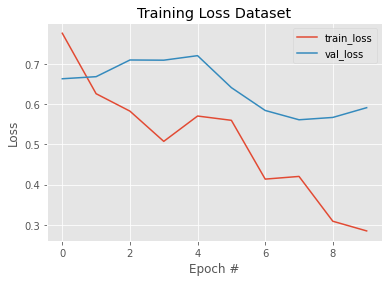

In [21]:
plot_history(history)

## Let's try another experiment where we add a few more dense layers:

In [ ]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
new_model.summary()

In [ ]:
## Just run a single epoch to see how it does:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

In [ ]:
plot_history(history)

## Now let's add dropout and another fully connected layer:

In [ ]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Adding a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data
new_model.add(Dropout(0.5))

# Adding a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Adding a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data
new_model.add(Dropout(0.5))

# Adding a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Adding a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data
new_model.add(Dropout(0.5))

# Adding a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Adding a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
new_model.summary()

In [ ]:
## Just run a single epoch to see how it does:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

In [ ]:
plot_history(history)

What's interesting about the small number of epochs we ran on the three different architectures above is that the simplest archiecture seemed to show the fastest learning. Why might that be? 

Answer: ? 